### Данные о клиентах банка:

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

### Данные, связанные с последним контактом:

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

### Прочие признаки:

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

### Целевой признак:

- deposit.

# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
col_null_percent=df.isnull().sum()
col_null=col_null_percent[col_null_percent>0]
col_null

balance    25
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [5]:
df.describe()

,age,day,duration,campaign,pdays,previous
count,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000
mean,41.231948,15.658036,371.993818,2.508421,51.330407,0.832557
std,11.913369,8.420740,347.128386,2.722077,108.758282,2.292007
min,18.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,8.000000,138.000000,1.000000,-1.000000,0.000000
50%,39.000000,15.000000,255.000000,2.000000,-1.000000,0.000000
75%,49.000000,22.000000,496.000000,3.000000,20.750000,1.000000
max,95.000000,31.000000,3881.000000,63.000000,854.000000,58.000000


### Задание 2

In [6]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df.job.value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [7]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
df.balance.value_counts()

0  $            774
 1,00 $          39
 3,00 $          34
 2,00 $          34
 4,00 $          29
               ... 
 1 641,00 $       1
 5 517,00 $       1
 8 332,00 $       1
 4 859,00 $       1
-134,00 $         1
Name: balance, Length: 3802, dtype: int64

In [8]:
df.balance=df['balance'].str.replace(',00','').str.replace('$','').str.replace(' ','').astype('float')

In [9]:
round(df.balance.mean(),3)

1529.129

### Задание 4

In [10]:
df.balance=df.balance.fillna(df.balance.median())

In [11]:
round(df.balance.mean(),3)

1526.936

### Задание 5

In [12]:
job_mode=df.job.mode()[0]

In [13]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
df.job=df.job.apply(lambda x:x if x!='unknown' else job_mode)

In [14]:
df.education.value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

In [15]:
edu_mode=df.education.mode()[0]
df.education=df.education.apply(lambda x:x if x!='unknown' else edu_mode)

In [16]:
balance_mode=round(df.balance[(df['education']==edu_mode)&(df['job']==job_mode)].mean(),3)
balance_mode

1598.883

### Задание 6

In [17]:
df_copy=df.copy()

<Axes: >

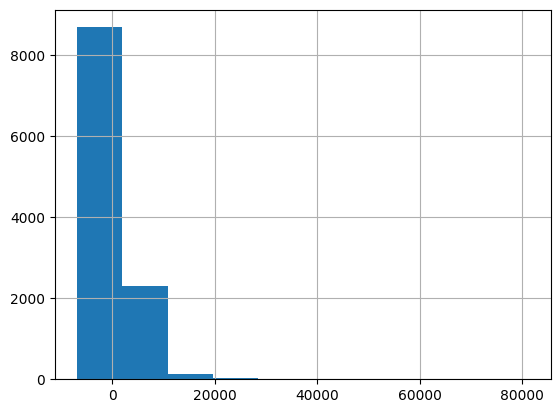

In [18]:
df.balance.hist()

In [19]:
# удалите все выбросы для признака balance
#добавим функцию для обнаружения выбросов метод z-отклонений
def outliers_z_score_mod(data, feature, left=3, right=3, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [20]:
Q1=np.percentile(df_copy.balance,25)
Q3=np.percentile(df_copy.balance,75)
IQR=Q3-Q1
IQR, Q1,Q3

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
lower_bound,upper_bound


(-2241.0, 4063.0)

In [21]:
outliers = df[(df.balance < lower_bound) | (df.balance > upper_bound)]
cleaned = df[(df.balance > lower_bound) & (df.balance < upper_bound)]

In [22]:
print (f'Число выбросов по методу Тьюки: {outliers.shape[0]}')



Число выбросов по методу Тьюки: 1057


In [23]:
df_copy=df_copy.drop(outliers.index)

## Часть 2:  Разведывательный анализ

### Задание 1

Количество клиентов без депозита : 5424
Количество клиентов с депозита: 4681


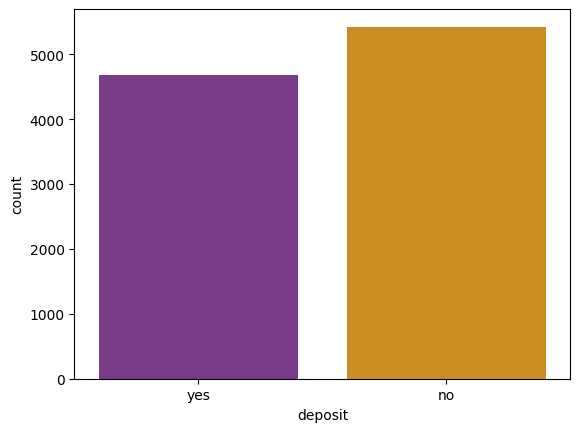

In [24]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(x='deposit', data=df_copy, palette='CMRmap')
class_deposit = df_copy['deposit'].value_counts()
print('Количество клиентов без депозита : {}'.format(class_deposit[0]))
print('Количество клиентов с депозита: {}'.format(class_deposit[1]))

### Задания 2 и 3

In [25]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
df_copy.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


In [26]:
types = df_copy.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

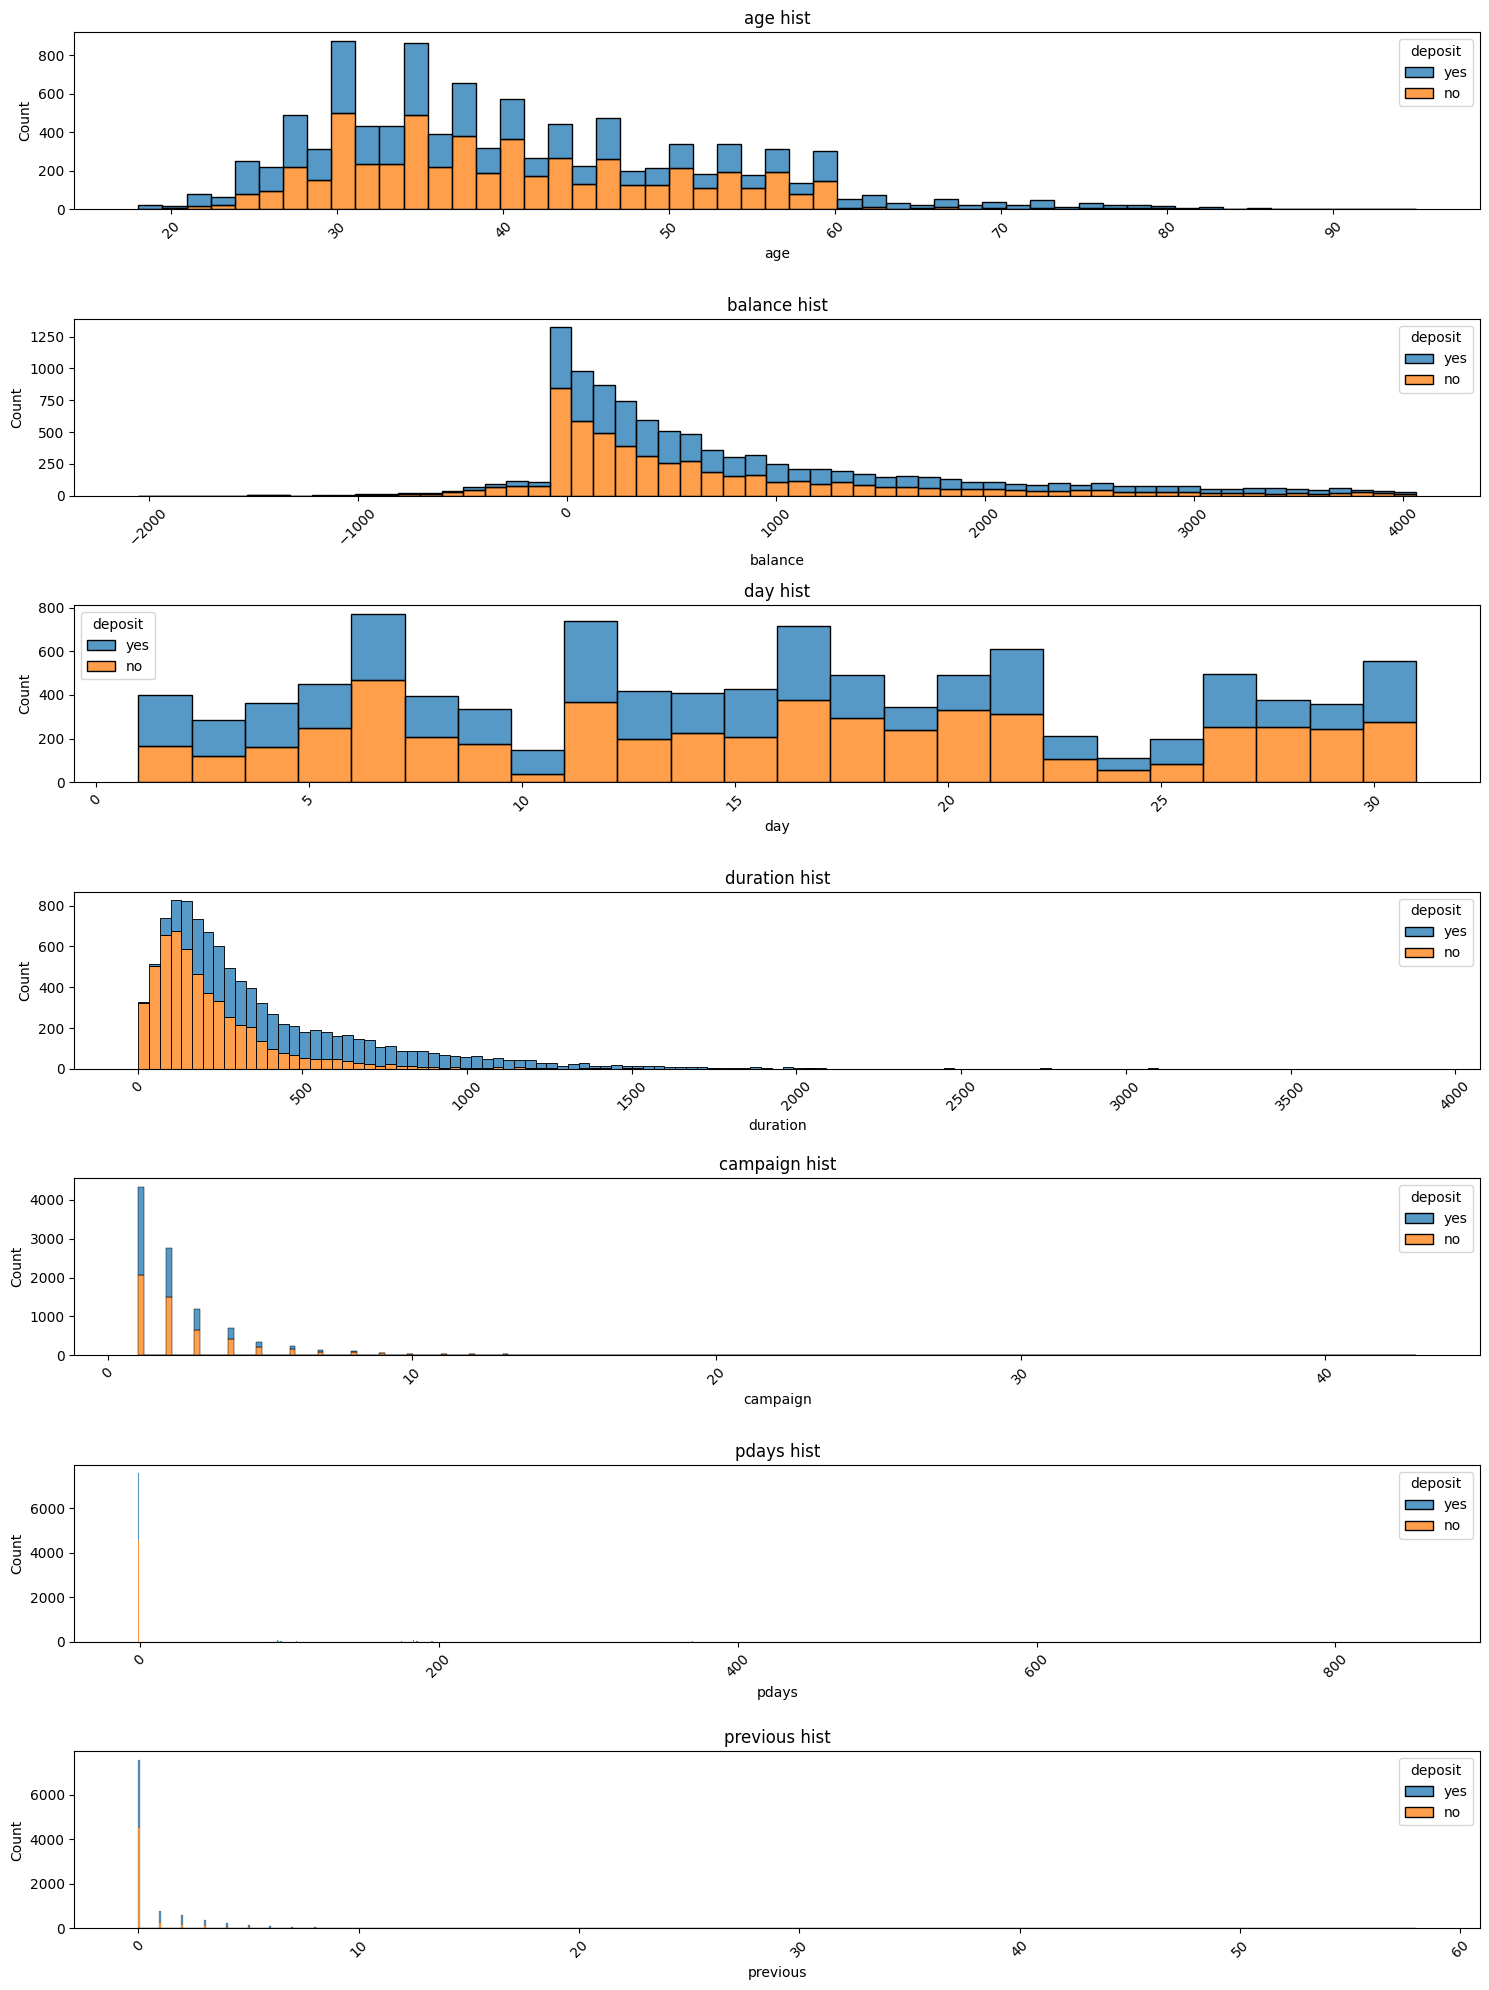

In [27]:
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n,1, figsize=(15, 20)) # фигура
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака
    histplot = sns.histplot(data=df_copy, x=feature, hue='deposit',multiple="stack", ax=axes[i])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)

plt.tight_layout() #выравнивание графиков

### Задания 4 и 5

In [28]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df_copy.describe(include=[object])
#постройте визуализации, иллюстрирующие результаты

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


In [29]:
count_data = (df_copy['job'].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  )
count_data

management       0.229095
blue-collar      0.178822
technician       0.162098
admin.           0.123305
services         0.085898
retired          0.065611
self-employed    0.035428
unemployed       0.032855
student          0.032261
entrepreneur     0.029688
housemaid        0.024938
Name: percentage, dtype: float64

In [30]:
cat_features = list(types[(types == 'object')].index)

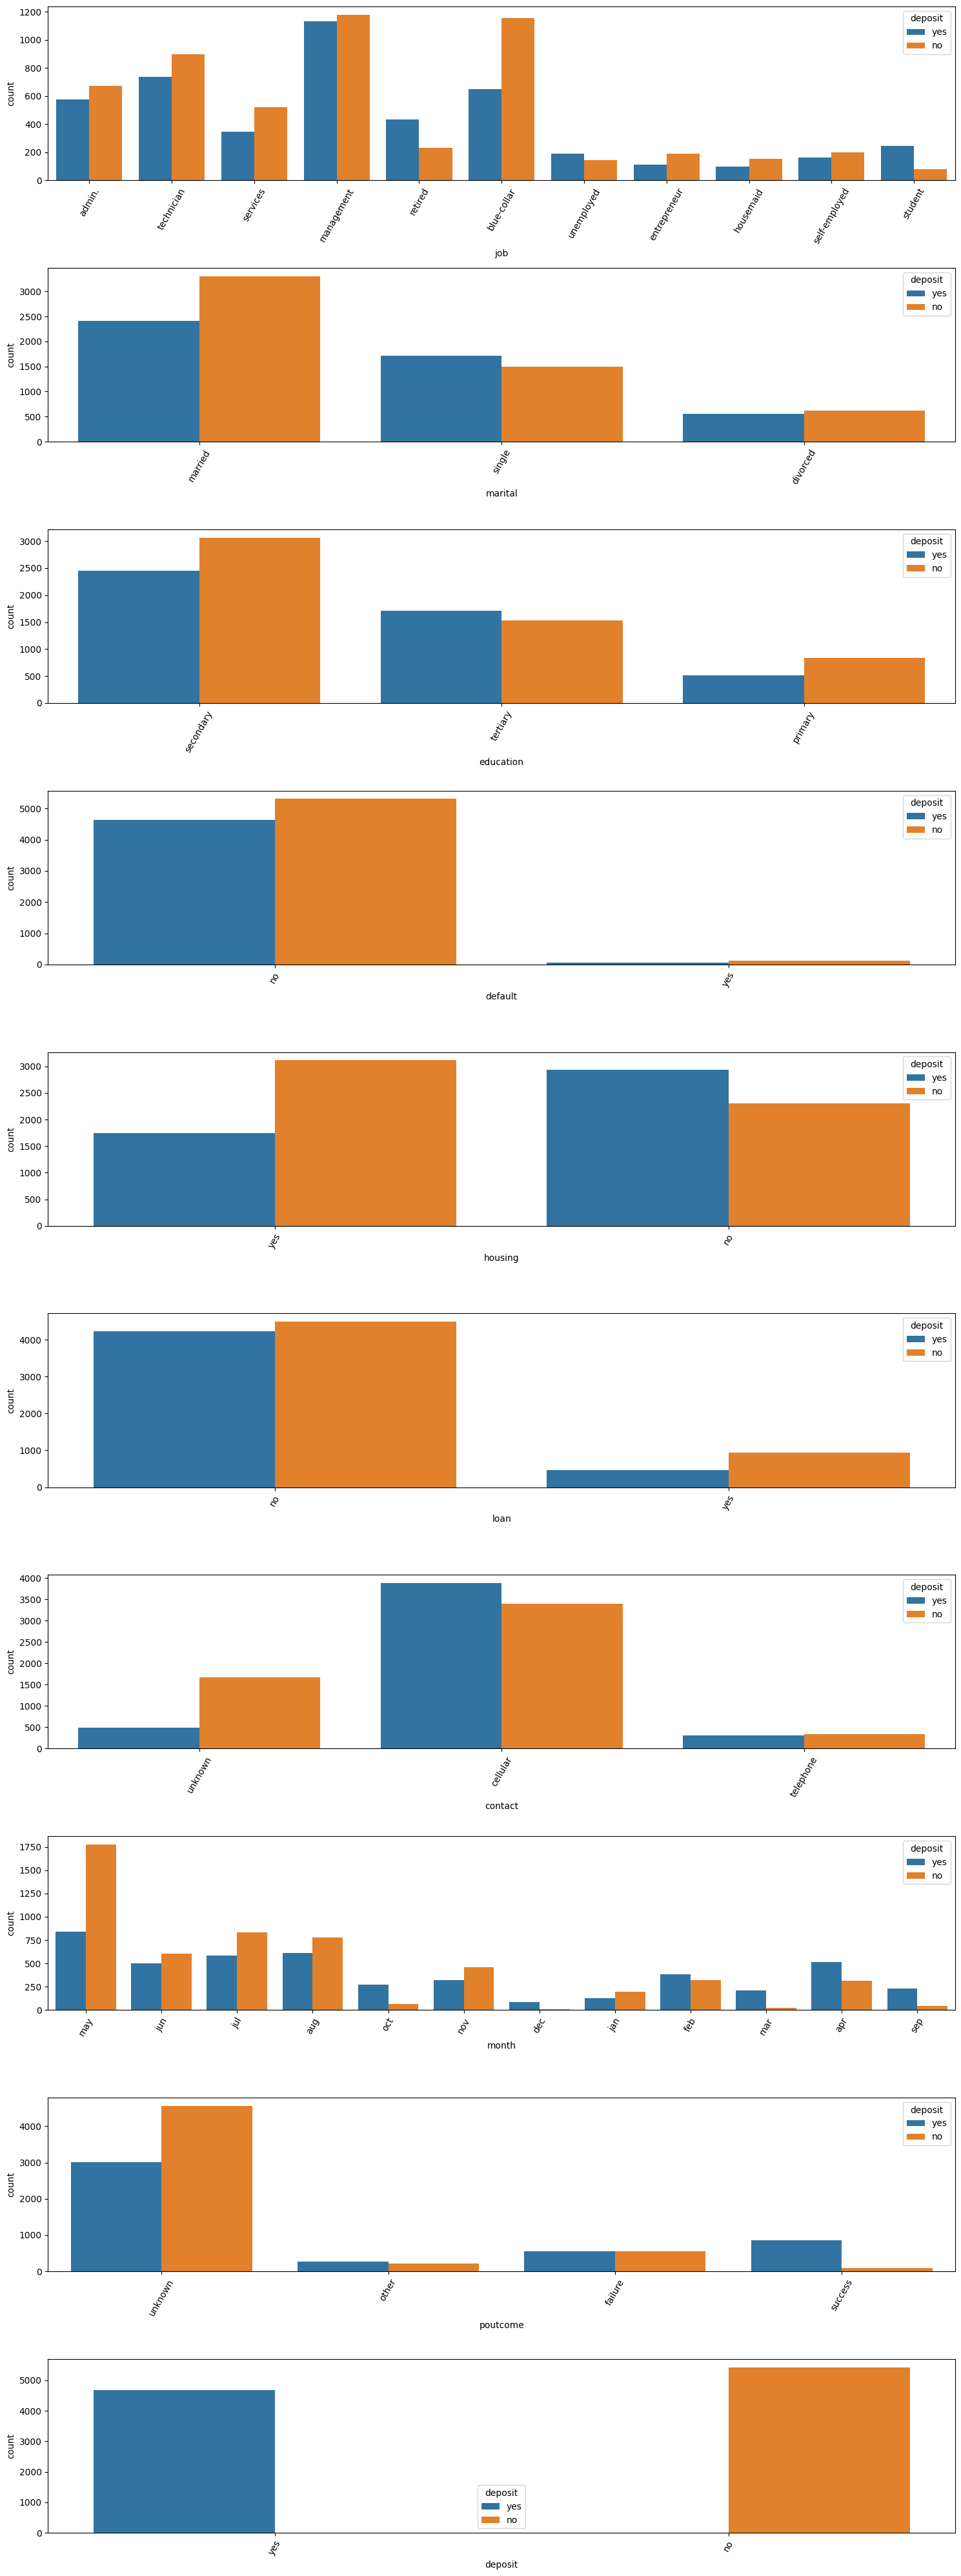

In [31]:
n = len(cat_features) #число категориальных признаков
fig, axes = plt.subplots(n, 1, figsize=(15, 40)) #фигура+n*2 координатных плоскостей
#Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    count_plot = sns.countplot(data=df_copy, x=feature, hue='deposit', ax=axes[i])
    count_plot.xaxis.set_tick_params(rotation=60)
plt.tight_layout() #выравнивание графиков

### Задание 6

<Axes: xlabel='deposit'>

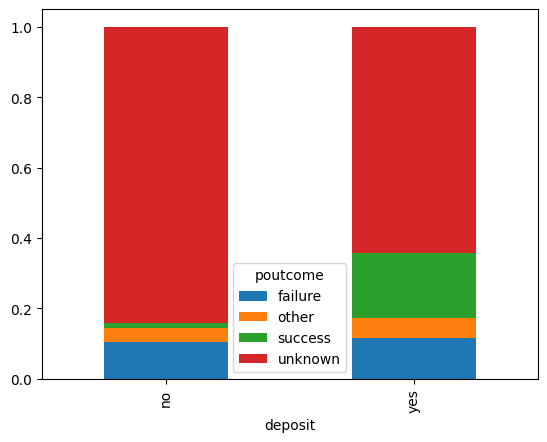

In [32]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
poutcome_types=df_copy.poutcome.groupby(df_copy.deposit).value_counts(normalize=True).unstack()
poutcome_types.plot(kind='bar', stacked='True')

### Задание 7

In [33]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
df_copy[df_copy.deposit=='no'].month.value_counts()

may    1776
jul     836
aug     775
jun     606
nov     456
feb     323
apr     317
jan     194
oct      62
sep      46
mar      24
dec       9
Name: month, dtype: int64

### Задание 8

<Axes: xlabel='age_group', ylabel='count'>

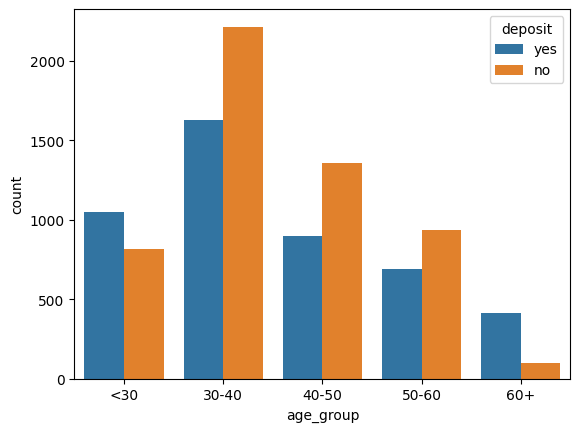

In [34]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
df_copy['age_group'] = pd.cut(df_copy.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df_copy)

### Задания 9 и 10

<Axes: xlabel='marital', ylabel='count'>

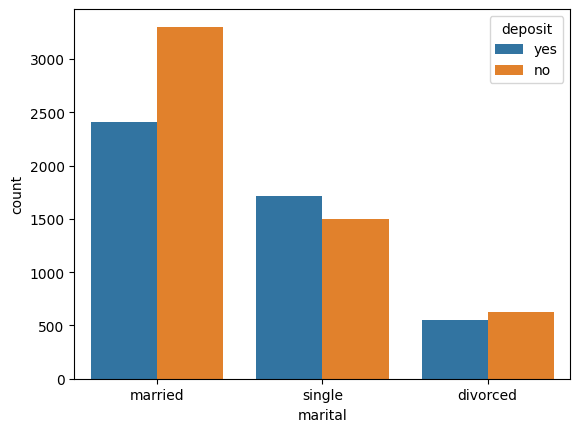

In [35]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
sns.countplot(x="marital", hue="deposit", data=df_copy)

<Axes: xlabel='education', ylabel='count'>

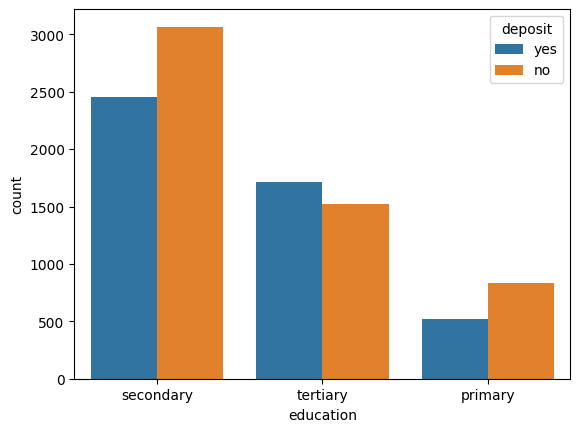

In [36]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
sns.countplot(x="education", hue="deposit", data=df_copy)

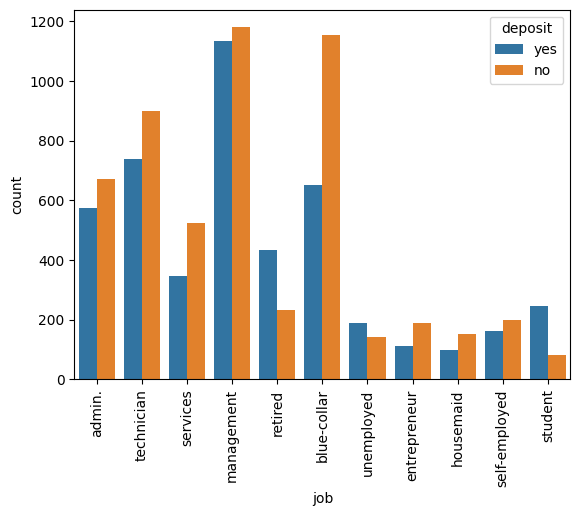

In [37]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
job_plot=sns.countplot(x="job", hue="deposit", data=df_copy)
job_plot.tick_params(axis='x', rotation=90)

### Задание 11

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


<Axes: xlabel='education', ylabel='marital'>

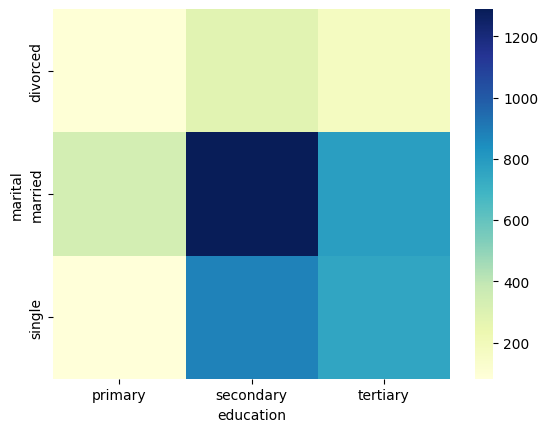

In [38]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
df_deposit=df_copy[df_copy.deposit=='yes']
crosstab=pd.crosstab(df_deposit.marital, df_deposit.education)
display(crosstab)
sns.heatmap(crosstab, cmap="YlGnBu")

education,primary,secondary,tertiary
marital,,,
divorced,91,370,163
married,641,1830,832
single,100,866,531


<Axes: xlabel='education', ylabel='marital'>

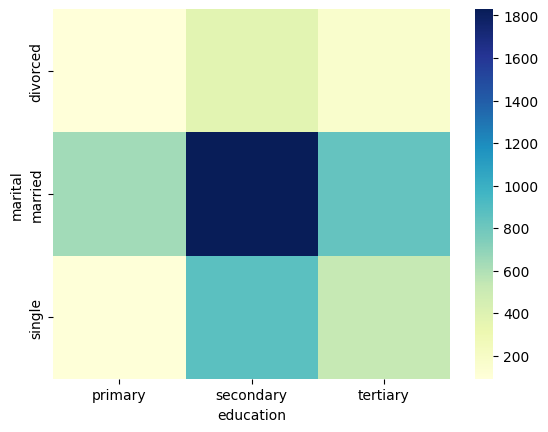

In [39]:
df_no_deposit=df_copy[df_copy.deposit=='no']
crosstab2=pd.crosstab(df_no_deposit.marital, df_no_deposit.education)
display(crosstab2)
sns.heatmap(crosstab2, cmap="YlGnBu")

## Часть 3: преобразование данных

### Задание 1

In [40]:
# преобразуйте уровни образования
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df_copy['education'] = lab_enc.fit_transform(df_copy['education'])
df_copy['education'].sum()

11995

In [41]:
df_copy.drop('age', axis=1)

,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,blue-collar,single,0,no,1.0,yes,no,cellular,20,apr,257,1,-1,0,unknown,no,30-40
11158,services,married,1,no,733.0,no,no,unknown,16,jun,83,4,-1,0,unknown,no,30-40
11159,technician,single,1,no,29.0,no,no,cellular,19,aug,156,2,-1,0,unknown,no,30-40
11160,technician,married,1,no,0.0,no,yes,cellular,8,may,9,2,172,5,failure,no,40-50


In [42]:
# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder()

# Кодирование признака
df_copy['age_group'] = lab_enc.fit_transform(df_copy['age_group'])


### Задания 2 и 3

In [43]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df_copy.deposit=df_copy.deposit.apply(lambda x: 1 if x=='yes' else 0)
df_copy.deposit

0        1
1        1
2        1
3        1
4        1
        ..
11157    0
11158    0
11159    0
11160    0
11161    0
Name: deposit, Length: 10105, dtype: int64

In [44]:
print(f'Cтандартное отклонение {df_copy.deposit.std():0.3f}')

Cтандартное отклонение 0.499


In [45]:
# Создание экземпляра класса LabelBinarizer()
lab_bin = preprocessing.LabelBinarizer()

# Кодирование признака
df_copy['default'] = lab_bin.fit_transform(df_copy['default'])


In [46]:
# Создание экземпляра класса LabelBinarizer()
lab_bin = preprocessing.LabelBinarizer()

# Кодирование признака
df_copy['housing'] = lab_bin.fit_transform(df_copy['housing'])

In [47]:
# Создание экземпляра класса LabelBinarizer()
lab_bin = preprocessing.LabelBinarizer()

# Кодирование признака
df_copy['loan'] = lab_bin.fit_transform(df_copy['loan'])

In [48]:
print(f"Cреднее арифметическое для каждой из получившихся переменных {df_copy['default'].mean()+df_copy['housing'].mean()+df_copy['loan'].mean():0.3f}")

Cреднее арифметическое для каждой из получившихся переменных 0.635


### Задание 4

In [49]:
# создайте дамми-переменные
df_dummies=pd.get_dummies(df_copy, drop_first=False)

In [50]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  int64  
 4   default    10105 non-null  int64  
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  int64  
 7   loan       10105 non-null  int64  
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  int64  
 17  age_group  10105 non-null  int64  
dtypes: float64(1), int64(12), object(5)
memory usage: 1.5+ MB


In [51]:
df_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int64  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_group          10105 non-null  int64  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

In [52]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

corr=df_dummies.corr()

<Axes: >

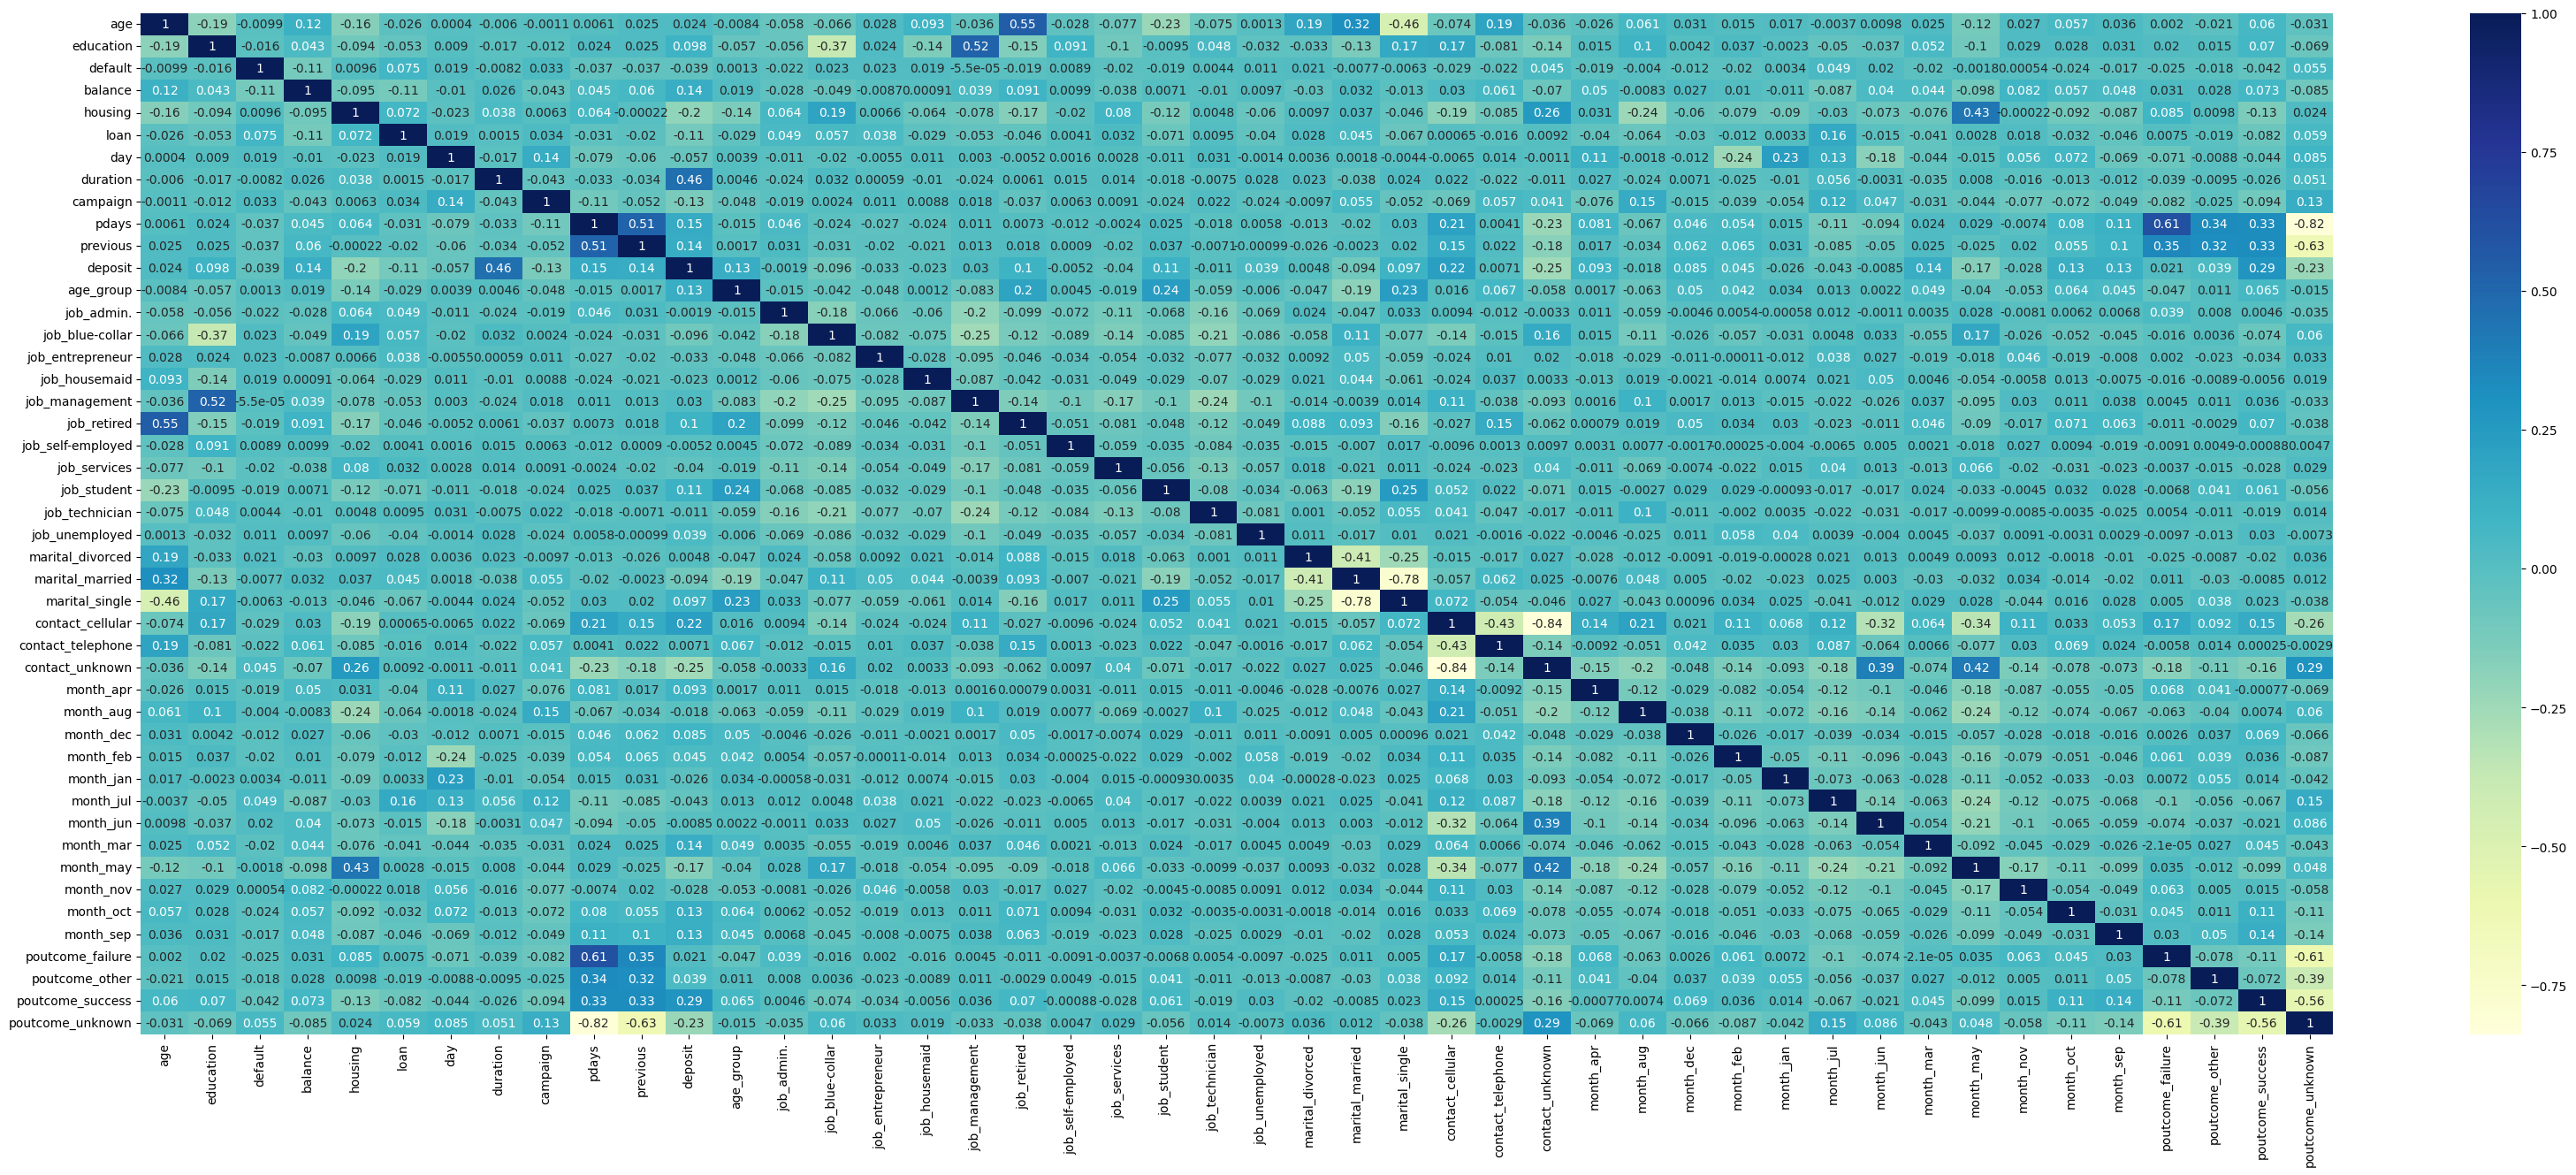

In [53]:
fig, ax = plt.subplots(figsize=(40, 15))
sns.heatmap(corr, annot=True, cmap="YlGnBu")

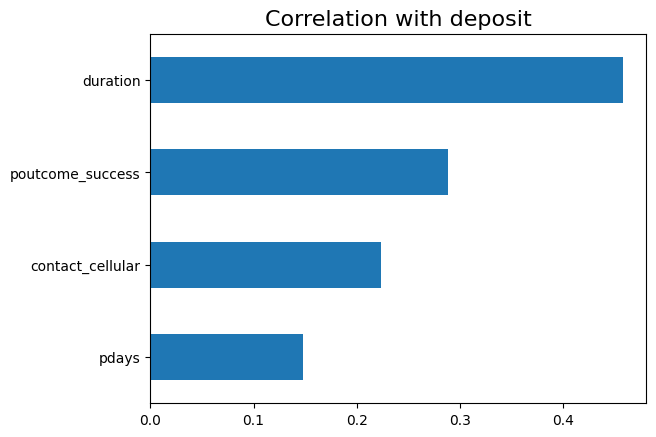

In [54]:
corr["deposit"].sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

In [55]:
# проверка на мультиколлинеарность
corr_feat=corr['deposit'].sort_values(ascending=False)
corr_feat[corr_feat>0.9]

deposit    1.0
Name: deposit, dtype: float64

### Задания 7 и 8

In [56]:
X = df_dummies.drop(['deposit'], axis=1)
y = df_dummies['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [57]:
# рассчитайте необходимые показатели
print(f'Размер тестовой выборки :{X_test.shape[0]}')

print(f'Cреднее значение целевой переменной на тестовой выборке :{y_test.mean():0.2f}')

Размер тестовой выборки :3335
Cреднее значение целевой переменной на тестовой выборке :0.46


### Задание 9

In [58]:
from sklearn.feature_selection import SelectKBest, f_regression

In [59]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(f_regression, k=15)
selector.fit(X_train, y_train)

columns_freg=selector.get_feature_names_out()
columns_freg

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

### Задание 10

In [60]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train[columns_freg])                           # fit() только на train данных
X_train_scaled = scaler.transform(X_train[columns_freg])    # fransform() на train данных
X_test_scaled = scaler.transform(X_test[columns_freg])      # fransform() на test данных

print(f'Среднее арифметическое для первого предиктора {X_test_scaled[:, 0].mean()}')

Среднее арифметическое для первого предиктора 0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [61]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(
    solver='sag',
    random_state=42,
    max_iter=1000 )

log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42, solver='sag')

In [62]:
#Выводим значения метрики
y_train_pred = log_reg.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred = log_reg.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train: 0.82
Test: 0.81


### Задания 2,3,4

In [63]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    #max_depth = 6
)

dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

In [64]:
#Выводим значения метрики
y_train_pred = dt.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred =dt.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.75


In [65]:
# обучите решающие деревья, настройте максимальную глубину
dt2 = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)

dt2.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [66]:
#Выводим значения метрики
y_train_pred = dt2.predict(X_train_scaled)
print('Train: {:.5f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred =dt2.predict(X_test_scaled)
print('Test: {:.5f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train: 0.81802
Test: 0.80660


In [67]:
dt3 = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 7
)

dt3.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=42)

In [68]:
#Выводим значения метрики
y_train_pred = dt3.predict(X_train_scaled)
print('Train: {:.5f}'.format(metrics.accuracy_score(y_train, y_train_pred)))
y_test_pred =dt3.predict(X_test_scaled)
print('Test: {:.5f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Train: 0.83663
Test: 0.81499


### Задание 5

In [69]:
# подберите оптимальные параметры с помощью gridsearch
from sklearn.model_selection import GridSearchCV

parameters =  {'min_samples_split': [2, 5, 7, 10], 'max_depth':[3,5,7]}

model_cv = GridSearchCV(tree.DecisionTreeClassifier(),
                        parameters,
                        cv=3, scoring=('f1'),
                        return_train_score=True)

model_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [3, 5, 7],
                         'min_samples_split': [2, 5, 7, 10]},
             return_train_score=True, scoring='f1')

In [70]:
print("Наилучшие значения гиперпараметров: {}".format(model_cv.best_params_))

Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


In [71]:
#Выводим значения метрики
y_train_pred = model_cv.predict(X_train_scaled)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred =model_cv.predict(X_test_scaled)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 0.83
Test: 0.80


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [72]:
# обучите на ваших данных случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators=100,
    criterion='gini',
    min_samples_leaf=5,
    max_depth=10,
    random_state=42
)
#Обучаем модель
rf.fit(X_train_scaled, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

In [73]:
# Выводим значения метрики для обучающей выборки
y_train_pred_rf =rf.predict(X_train_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred_rf)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred_rf)))
#Рассчитываем f1-score
print('F1-score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_rf)))

Accuracy: 0.86
Recall: 0.86
F1-score: 0.85


In [80]:
# Выводим значения метрики для тестовой выборки
y_test_pred_rf =rf.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_rf)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred_rf)))
#Рассчитываем f1-score
print('F1-score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf)))
#Рассчитываем precision
print('precision-score: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred_rf)))

Accuracy: 0.83
Recall: 0.83
F1-score: 0.82
precision-score: 0.80


### Задания 2 и 3

In [75]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

GradientBoostingClassifier(learning_rate=0.05, max_depth=5, min_samples_leaf=5,
                           n_estimators=300, random_state=42)

In [76]:
# Выводим значения метрики для обучающей выборки
y_train_pred_gb =gb.predict(X_train_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_train_pred_gb )))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y_train, y_train_pred_gb )))
#Рассчитываем f1-score
print('F1-score: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred_gb )))

Accuracy: 0.89
Recall: 0.89
F1-score: 0.88


In [81]:
# Выводим значения метрики для тестовой выборки
y_test_pred_gb =gb.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_gb)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred_gb)))
#Рассчитываем f1-score
print('F1-score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_gb)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred_gb)))

Accuracy: 0.83
Recall: 0.83
F1-score: 0.82
Precision: 0.80


In [78]:
print(f'Случайный лес {metrics.classification_report(y_test, y_test_pred_rf)}')
print(f'Градиентный бустинг {metrics.classification_report(y_test, y_test_pred_gb)}')

Случайный лес               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

Градиентный бустинг               precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [82]:
# объедините уже известные вам алгоритмы с помощью стекинга
estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [83]:
# Выводим значения метрики для тестовой выборки
y_test_pred_st =stack.predict(X_test_scaled)
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_st)))
#Рассчитываем recall
print('Recall: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred_st)))
#Рассчитываем f1-score
print('F1-score: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_st)))
#Рассчитываем precision
print('Precision: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred_st)))

Accuracy: 0.82
Recall: 0.81
F1-score: 0.81
Precision: 0.81


### Задание 5

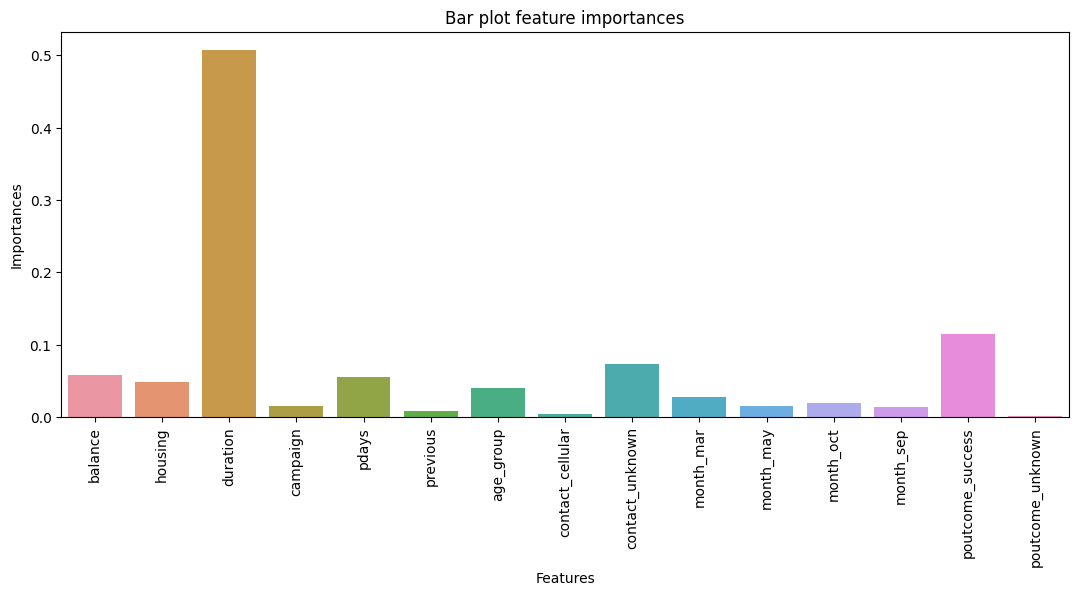

In [88]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
fig, ax = plt.subplots(figsize=(13, 5)) #фигура + координатная плоскость
feature = X_test[columns_freg].columns #признаки
feature_importances = gb.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances')
ax.tick_params(axis='x', rotation=90)

### Задания 6,7,8

In [90]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 6.3 MB/s eta 0:00:00


In [91]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.2.0


In [100]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))


  return score

In [94]:
random_state=42

In [101]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2023-07-23 12:36:08,365] A new study created in memory with name: RandomForestClassifier
[I 2023-07-23 12:36:09,485] Trial 0 finished with value: 0.8805759899827829 and parameters: {'n_estimators': 151, 'max_depth': 24, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.8805759899827829.
[I 2023-07-23 12:36:10,373] Trial 1 finished with value: 0.8607515983159207 and parameters: {'n_estimators': 129, 'max_depth': 22, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8805759899827829.
[I 2023-07-23 12:36:11,631] Trial 2 finished with value: 0.8604832424006235 and parameters: {'n_estimators': 185, 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8805759899827829.
[I 2023-07-23 12:36:12,733] Trial 3 finished with value: 0.856920442160984 and parameters: {'n_estimators': 167, 'max_depth': 16, 'min_samples_leaf': 7}. Best is trial 0 with value: 0.8805759899827829.
[I 2023-07-23 12:36:13,690] Trial 4 finished with value: 0.9149136577708006 and parameters: {'n_e

CPU times: user 22.9 s, sys: 77.9 ms, total: 23 s
Wall time: 23.1 s


In [102]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 165, 'max_depth': 27, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [104]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("f1 на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('accuracy_score на тестовом наборе: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

f1 на тестовом наборе: 0.83
accuracy_score на тестовом наборе: 0.83
